In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [ ]:
print(tf.__version__)

2.18.0


In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')



84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
dataset_dir = dataset
os.listdir(dataset_dir)

['aclImdb']

In [ ]:
dataset_dir = os.path.join(dataset, 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_pos.txt',
 'unsup',
 'pos',
 'urls_neg.txt',
 'unsupBow.feat',
 'urls_unsup.txt',
 'labeledBow.feat',
 'neg']

In [ ]:
os.listdir(dataset_dir)

['imdbEr.txt', 'imdb.vocab', 'test', 'train', 'README']

In [ ]:
#Data preprocessing
removal=os.path.join(train_dir,'unsup')
shutil.rmtree(removal)

In [ ]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=32,
    validation_split=0.2,
    subset='training',
    seed=42)

raw_val_ds=tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=32,
    validation_split=0.2,
    subset='validation',
    seed=42)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir,'test'),
    batch_size=32)

Found 25000 files belonging to 2 classes.


In [ ]:
def standardization(input_text):
    text = tf.strings.lower(input_text)
    text = tf.strings.regex_replace(text, "<br />'", " ")
    text = tf.strings.regex_replace(text, r"\d+", "")
    text = tf.strings.regex_replace(text, f"[{re.escape(string.punctuation)}]", "")
    text = tf.strings.regex_replace(text, r"\s+", " ")
    return text

max_token=10000
seq_length=250

vectorise_layer=layers.TextVectorization(
    standardize=standardization,
    max_tokens=max_token,
    output_mode='int',
    output_sequence_length=seq_length

)

In [ ]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorise_layer.adapt(train_text)

In [ ]:
#test above function
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorise_layer(text), label
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"Having seen most of Ringo Lam's films, I can say that this is his best film to date, and the most unusual. It's a ancient china period piece cranked full of kick-ass martial arts, where the location of an underground lair full of traps and dungeons plays as big a part as any of the characters. The action is fantastic, the story is tense and entertaining, and the set design is truely memorable. Sadly, Burning Paradise has not been made available on DVD and vhs is next-to-impossible to get your mitts on, even if you near the second biggest china-town in North America (like I do). If you can find it, don't pass it up.", shape=(), dtype=string)
Label pos
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 255,  107,   88,    5,    1,    1,   95,   10,   68,  130,   12,
          11,    7,   25,  115,   20,    6, 1293,    3,    2,   88, 1590,
          30,    4, 2179, 2675,  862,  409,    1,  373,    5,    1, 1660,
        1720,  114,    2, 1648,  

In [ ]:
train_ds=raw_train_ds.map(vectorize_text)
test_ds=raw_test_ds.map(vectorize_text)
val_ds=raw_val_ds.map(vectorize_text)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_token, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])


In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.5824 - loss: 0.6821 - val_binary_accuracy: 0.7376 - val_loss: 0.6152
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.7515 - loss: 0.5835 - val_binary_accuracy: 0.8104 - val_loss: 0.5025
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8154 - loss: 0.4738 - val_binary_accuracy: 0.8342 - val_loss: 0.4299
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8435 - loss: 0.4031 - val_binary_accuracy: 0.8482 - val_loss: 0.3865
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - binary_accuracy: 0.8632 - loss: 0.3565 - val_binary_accuracy: 0.8532 - val_loss: 0.3599
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8766 - loss: 0.3239 - val_binary_accuracy: 0.8590 - val_loss: 0.3406
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - binary_accuracy: 0.8862 - loss: 0.2987 - val_binary_accuracy: 0.8644 - val_loss: 0.3274
Epoch 

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - binary_accuracy: 0.8637 - loss: 0.3268
Loss:  0.32661935687065125
Accuracy:  0.8632799983024597


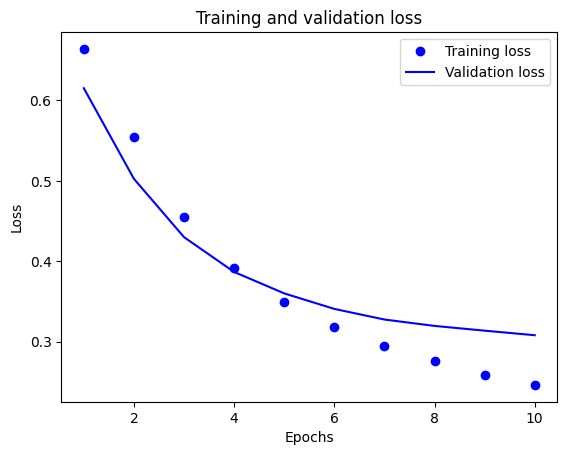

In [ ]:
history_dict = history.history
history_dict.keys()
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

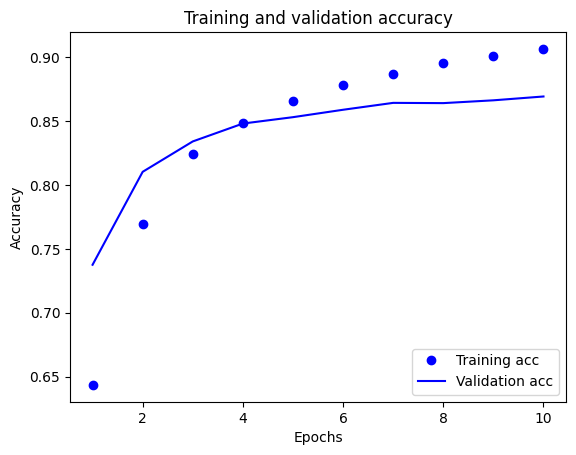

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
export_model = tf.keras.Sequential([
  vectorise_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
metrics = export_model.evaluate(raw_test_ds, return_dict=True)
print(metrics)

examples = tf.constant([
  "The movie was fine!",
  "The movie was amazing.",
  "The movie was epic...",
  "The movie was very bad"
])

predictions = export_model.predict(examples)

for i, pred in enumerate(predictions):
    sentiment = "positive" if pred > 0.5 else "negative"
    print(f"Review {i+1}: {sentiment} (score: {pred[0]:.4f})")


782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5017 - loss: 0.5898


{'accuracy': 0.5000399947166443, 'loss': 0.5899723172187805}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Review 1: positive (score: 0.5951)
Review 2: positive (score: 0.6167)
Review 3: positive (score: 0.5870)
Review 4: positive (score: 0.5597)
